In [192]:
import networkx as nx
from networkx.convert_matrix import to_numpy_array
from networkx.algorithms.centrality import betweenness_centrality
import numpy as np
import tensorflow as tf
import keras
import time
from scipy.stats import kendalltau as kt
import random
from utils import get_graph, get_bc_info, clean_adj_matrix
from GNN_BC import GNN_BC
from GNN_BC_2 import GNN_BC_2
from MLP import NeuralNet
import itertools
random.seed(10)

#Prevents warnings from popping up
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
params = {
    'num_epochs': 10,
    'learning_rate' : 0.0001,
    'n_messaging_cells': 3,
    'hidden_neurons_messaging_cells': 20,
    'mlp_hidden_layers': [30,30,30],
    'GNN_layer_activation': tf.keras.activations.swish,
    'mlp_activation': tf.keras.activations.swish,
    'pairs_sample_size': 1000,
    'margin': 1
}


In [170]:
def get_random_graph(num_nodes,num_edges,index):
    """Generate and return different types of graphs."""

    if index==0:
        g = nx.gnm_random_graph(num_nodes,num_edges, directed=True)
        return g

    elif index==1:
        g = nx.barabasi_albert_graph(num_nodes,num_nodes-1)
        return g

    elif index==2:
        g = nx.powerlaw_cluster_graph(num_nodes,num_nodes-1,0.2)
        return g

    elif index==3:
        p = (num_edges/(num_nodes*num_nodes))
        g = nx.fast_gnp_random_graph(num_nodes,p)
        return g

    elif index==4:
        #parameters taken from NetworkX example
        g = nx.gaussian_random_partition_graph(100,10,10,.25,.1,directed=False)
        return nx.Graph(g)

    elif index==5:
        g = nx.watts_strogatz_graph(num_nodes,3,0.1)
        return g

In [205]:

def train(model, adj_matrices, adj_matrices_t, real_BCs_list, num_epochs):
    losses= []
    for i in range(num_epochs):
        print('epoch',i+1)
        kt_scores = []
        top_10s = []
        for adj, adj_t, real_bcs in zip(adj_matrices, adj_matrices_t, real_BCs_list):
            model.real_BCs = real_bcs
            loss = model.train_on_batch(np.asarray((adj, adj_t)), return_dict=True)['loss']
            print('loss:',loss)
            losses.append(loss)
            
            #scores = np.asarray(list(itertools.chain.from_iterable(model.call((adj, adj_t)))))
            scores = np.asarray(list(itertools.chain.from_iterable(model.call(adj))))
            #print('scores:',scores)
            N = len(real_bcs)
            top_predicted = scores.argsort()[-N:][::-1]
            top_real = np.asarray(list(real_bcs.values())).argsort()[-N:][::-1]
            

            kt_scores.append(kt(top_predicted, top_real).correlation)
            
            N = int(0.1*len(real_bcs))
            top_predicted = scores.argsort()[-N:][::-1]
            top_real = np.asarray(list(real_bcs.values())).argsort()[-N:][::-1]
            #print('top_predicted:', top_predicted)
            #print('top_real:     ', top_real)
            overlap = set(top_predicted) & set(top_real)
            universe = set(top_predicted) | set(top_real)

            top_10s.append(len(overlap)/len(universe))
            
        avg_kt = np.mean(np.asarray(kt_scores))
        avg_top10 = np.mean(np.asarray(top_10s))
        print('average kt:', avg_kt)
        print('average top 10 %:', avg_top10)
        print()
    return losses
            

In [208]:
import importlib
import utils
importlib.reload(utils)
from utils import *
import importlib
import GNN_layers
importlib.reload(GNN_layers)
from GNN_layers import *
import importlib
import GNN_BC
importlib.reload(GNN_BC)
from GNN_BC import *
import importlib
import GNN_BC_2
importlib.reload(GNN_BC_2)
from GNN_BC_2 import *
from scipy.stats import kendalltau as kt

num_nodes = 100
num_edges = 400

indices = list(range(4,6))
random.shuffle(indices)

train_indices = indices[:1]
test_indices = indices[1:]

train_graph_list = []
test_graph_list = []

train_real_BCs = []
test_real_BCs = []

for _ in range(500): 
    for i in train_indices:
        g = get_random_graph(num_nodes, num_edges, i)
        train_graph_list.append(g)
        train_real_BCs.append(dict(sorted(betweenness_centrality(g).items())))
        

    for j in test_indices:
        g = get_random_graph(num_nodes, num_edges, j)
        test_graph_list.append(g)
        test_real_BCs.append(dict(sorted(betweenness_centrality(g).items())))

adj_matrices = []
adj_matrices_t = []
for graph in train_graph_list:
    adj = to_numpy_array(graph)
    adj_t = np.transpose(adj)

    adj_matrices.append(adj)
    adj_matrices_t.append(adj_t)

adj_matrices = np.asarray(adj_matrices)
adj_matrices_t = np.asarray(adj_matrices_t)

print(adj_matrices[0])
print(adj_matrices_t[0])



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]]


In [209]:
import importlib
import utils
importlib.reload(utils)
from utils import *
import importlib
import GNN_layers
importlib.reload(GNN_layers)
from GNN_layers import *
import importlib
import GNN_BC
importlib.reload(GNN_BC)
from GNN_BC import *
import importlib
import GNN_BC_2
importlib.reload(GNN_BC_2)
from GNN_BC_2 import *
import NeuralNet
importlib.reload(NeuralNet)
from NeuralNet import *
from scipy.stats import kendalltau as kt

optimizer = keras.optimizers.Adam(params['learning_rate'])
#model = GNN_BC(num_nodes, 1, params)
model = NeuralNet(num_nodes, 1, params)
model.compile(optimizer)
losses = train(model, adj_matrices, adj_matrices_t, train_real_BCs, num_epochs = 5)

epoch 1
x shape: (100, 100)
(100, 1)
x shape: (100, 100)
(100, 1)
loss: [1012.2056]
loss: [995.4244]
loss: [994.33185]
loss: [1018.4955]
loss: [1001.5903]
loss: [993.0555]
loss: [1008.3951]
loss: [1036.0619]
loss: [1011.6485]
loss: [989.363]
loss: [987.50415]
loss: [997.7317]
loss: [1030.2025]
loss: [993.3187]
loss: [995.2503]
loss: [1016.9839]
loss: [971.6006]
loss: [979.76355]
loss: [999.5107]
loss: [1000.0174]
loss: [973.407]
loss: [980.726]
loss: [1006.42755]
loss: [1009.64996]
loss: [1031.4174]
loss: [968.62494]
loss: [999.6976]
loss: [993.9458]
loss: [1000.5774]
loss: [1005.7094]
loss: [999.2537]
loss: [976.5791]
loss: [1005.5269]
loss: [1001.8165]
loss: [976.92377]
loss: [969.61566]
loss: [1004.4582]
loss: [980.31854]
loss: [998.33167]
loss: [1018.92926]
loss: [995.8153]
loss: [983.78625]
loss: [987.53033]
loss: [984.4581]
loss: [1036.0203]
loss: [991.6444]
loss: [1002.7588]
loss: [1022.40894]
loss: [997.73486]
loss: [1025.4471]
loss: [1007.7148]
loss: [997.80743]
loss: [989.642

loss: [1004.91864]
loss: [997.4123]
loss: [1012.1207]
loss: [1004.4519]
loss: [984.0444]
loss: [974.08167]
loss: [994.1236]
loss: [977.73773]
loss: [996.32605]
loss: [990.5179]
loss: [1020.0091]
loss: [967.9452]
loss: [1000.00793]
loss: [990.04156]
loss: [1011.49536]
loss: [961.3809]
loss: [991.0038]
loss: [1003.5669]
loss: [1009.27386]
loss: [999.4993]
loss: [1043.437]
loss: [998.2678]
loss: [1003.76666]
loss: [1000.8414]
loss: [970.4352]
loss: [1036.6721]
loss: [973.7881]
loss: [996.03357]
loss: [992.5903]
loss: [985.321]
loss: [1008.33417]
loss: [976.5498]
loss: [984.50195]
loss: [1002.30676]
loss: [991.298]
loss: [1001.86945]
loss: [989.5219]
average kt: 0.0015208080808080822
average top 10 %: 0.06888355693154455

epoch 2
loss: [1011.36426]
loss: [993.19775]
loss: [993.30286]
loss: [1016.7471]
loss: [1002.7075]
loss: [992.4541]
loss: [1009.04]
loss: [1035.8837]
loss: [1010.64716]
loss: [989.07666]
loss: [985.189]
loss: [995.7069]
loss: [1030.283]
loss: [993.5641]
loss: [994.803]
lo

loss: [1012.79803]
loss: [1002.75696]
loss: [976.22675]
loss: [999.9578]
loss: [987.3374]
loss: [985.0619]
loss: [1001.20447]
loss: [1019.9813]
loss: [1017.4665]
loss: [954.8867]
loss: [980.3008]
loss: [997.836]
loss: [997.10364]
loss: [1023.6436]
loss: [991.3179]
loss: [1019.9521]
loss: [992.22015]
loss: [997.01526]
loss: [1000.8969]
loss: [994.0065]
loss: [1005.2424]
loss: [977.8116]
loss: [1012.4508]
loss: [1017.5758]
loss: [1021.64984]
loss: [951.2322]
loss: [978.49426]
loss: [970.2643]
loss: [1026.889]
loss: [970.26025]
loss: [956.6077]
loss: [1007.9654]
loss: [1027.6604]
loss: [998.7848]
loss: [976.7103]
loss: [964.5984]
loss: [1007.42126]
loss: [989.7455]
loss: [1022.8018]
loss: [1004.7518]
loss: [997.4238]
loss: [1009.8163]
loss: [1002.5221]
loss: [983.41235]
loss: [972.46423]
loss: [992.9018]
loss: [977.3354]
loss: [995.81335]
loss: [988.8879]
loss: [1020.58734]
loss: [966.03687]
loss: [999.2562]
loss: [989.3124]
loss: [1011.309]
loss: [958.66174]
loss: [988.9877]
loss: [1002.

loss: [1001.63904]
loss: [967.9865]
loss: [990.4908]
loss: [1007.6312]
loss: [990.823]
loss: [1029.3418]
loss: [990.24005]
loss: [1007.3438]
loss: [982.76166]
loss: [993.8852]
loss: [1003.16534]
loss: [987.91016]
loss: [955.61554]
loss: [1017.5221]
loss: [1022.113]
loss: [971.9344]
loss: [970.6129]
loss: [1009.51685]
loss: [995.58923]
loss: [1010.6323]
loss: [1003.3553]
loss: [991.936]
loss: [980.0127]
loss: [979.24817]
loss: [971.9799]
loss: [965.9294]
loss: [1012.9929]
loss: [998.2746]
loss: [965.5097]
loss: [991.0332]
loss: [1012.26025]
loss: [987.76086]
loss: [1002.35754]
loss: [991.94324]
loss: [980.15845]
loss: [997.0123]
loss: [1041.9456]
loss: [984.906]
loss: [1011.1955]
loss: [1002.2176]
loss: [973.4211]
loss: [998.6462]
loss: [985.6464]
loss: [983.59344]
loss: [1000.004]
loss: [1019.17487]
loss: [1017.21655]
loss: [951.5162]
loss: [978.10626]
loss: [995.22845]
loss: [995.6786]
loss: [1025.8516]
loss: [991.1628]
loss: [1018.04974]
loss: [992.3846]
loss: [996.39276]
loss: [999.

loss: [996.3883]
loss: [1006.4875]
loss: [1017.1008]
loss: [984.32684]
loss: [1012.9068]
loss: [993.0539]
loss: [977.5826]
loss: [1014.71216]
loss: [1025.8766]
loss: [995.66943]
loss: [987.44293]
loss: [996.30554]
loss: [972.13293]
loss: [999.47253]
loss: [975.6586]
loss: [1021.7931]
loss: [971.00116]
loss: [975.05743]
loss: [1017.63635]
loss: [1013.5781]
loss: [999.8661]
loss: [1010.0817]
loss: [991.20404]
loss: [987.6245]
loss: [1015.72174]
loss: [1004.5614]
loss: [983.40466]
loss: [979.44684]
loss: [978.28485]
loss: [1002.3393]
loss: [1012.8075]
loss: [981.94543]
loss: [1008.58386]
loss: [979.51355]
loss: [1007.55475]
loss: [999.0902]
loss: [1000.3308]
loss: [965.9885]
loss: [989.9652]
loss: [1006.96]
loss: [990.59686]
loss: [1029.891]
loss: [990.2726]
loss: [1008.7344]
loss: [981.7375]
loss: [992.1744]
loss: [1002.76746]
loss: [985.53577]
loss: [953.59875]
loss: [1016.19476]
loss: [1023.1995]
loss: [971.42395]
loss: [968.53766]
loss: [1008.44525]
loss: [994.8259]
loss: [1009.0881]


loss: [990.32654]
loss: [1017.20044]
loss: [986.3319]
loss: [1004.27594]
loss: [976.4323]
loss: [978.64954]
loss: [1003.2767]
loss: [994.6118]
loss: [998.4475]
loss: [1023.2492]
loss: [976.70355]
loss: [1009.6382]
loss: [995.1717]
loss: [967.9043]
loss: [1022.1403]
loss: [1021.94165]
loss: [1017.39655]
loss: [964.7592]
loss: [1004.35004]
loss: [993.1061]
loss: [1014.29224]
loss: [1002.0736]
loss: [963.8464]
loss: [1007.51874]
loss: [994.844]
loss: [994.5173]
loss: [986.86383]
loss: [976.4285]
loss: [997.6702]
loss: [1017.23694]
loss: [971.76404]
loss: [989.153]
loss: [985.0173]
loss: [990.6108]
loss: [1005.2537]
loss: [994.77576]
loss: [1005.2295]
loss: [1017.3761]
loss: [982.38275]
loss: [1011.8319]
loss: [992.6969]
loss: [975.93774]
loss: [1013.85406]
loss: [1026.6885]
loss: [993.8991]
loss: [984.0607]
loss: [995.90027]
loss: [969.9329]
loss: [998.86127]
loss: [973.3682]
loss: [1021.0175]
loss: [969.07666]
loss: [972.3317]
loss: [1016.7368]
loss: [1014.22815]
loss: [999.04974]
loss: 

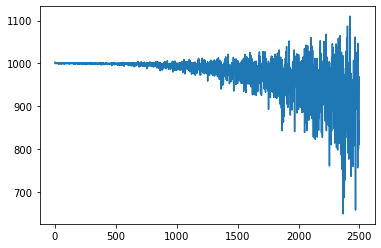

In [178]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)
plt.show()

In [60]:
scores = model.call((adj_matrices[0],adj_matrices_t[0]))
scores.numpy()[2]

array([ 1.5139759 , -0.74740213,  0.41952956,  0.9856248 , -0.98590875,
        0.47306967,  0.23463854, -0.7231367 ,  1.0200986 ,  0.52744603,
        0.44790065, -0.26508906, -0.4688629 , -1.1989939 ,  0.3531478 ,
        0.3725164 ,  0.7688761 , -0.22684282, -0.9277754 ,  0.43125483,
        0.2961935 ,  0.1014372 , -0.7914911 ,  1.1735218 ,  1.4328148 ,
        0.3201409 , -0.5154319 , -0.80007184, -0.40854004,  0.449941  ,
       -0.6504839 , -0.76677877,  1.204517  ,  1.7469306 ,  0.34200096,
        1.2508317 ,  0.70824313,  0.40501994,  0.28333598, -0.37746176,
       -1.3131219 , -1.0308589 , -0.88417464, -1.14511   ,  1.0798979 ,
       -1.1950283 ,  0.5594673 , -0.18868029, -0.8615738 , -0.50967115,
       -1.097316  ,  0.52731305, -0.50331223,  0.2799184 , -1.1472268 ,
        0.39270443,  1.890918  ,  0.53306395,  0.40031144,  0.39490077,
        0.8743203 ,  0.41164187, -0.760944  ,  1.2268847 , -1.3816631 ,
        0.3535563 , -0.52886605, -0.2780312 ,  0.38032156, -0.61

range(1)


In [164]:
range(1)

range(0, 1)